In [1]:
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, Input, concatenate
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_cnn(input_shape):
    # Define the CNN architecture
    input_img = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(input_img)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(512, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(512, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(512, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    cnn_output = Dense(256, activation='relu')(x)
    
    # Create and compile the CNN model
    cnn_model = Model(inputs=input_img, outputs=cnn_output)
    cnn_model.compile(optimizer='adam', loss='mean_absolute_error') # You can adjust the optimizer and loss function as needed
    return cnn_model

def create_dnn(input_shape):
    # Define the DNN architecture
    input_non_img = Input(shape=input_shape)
    x = Dense(128, activation='relu')(input_non_img)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(16, activation='relu')(x)
    
    # Create and compile the DNN model
    dnn_model = Model(inputs=input_non_img, outputs=dnn_output)
    dnn_model.compile(optimizer='adam', loss='mean_absolute_error') # You can adjust the optimizer and loss function as needed
    return dnn_model

def create_fusion_model(cnn_model, dnn_model):
    # Concatenate the outputs of the CNN and DNN models
    concatenated = concatenate([cnn_model.output, dnn_model.output])
    output = Dense(12, activation='relu')(concatenated) 

    
    # Create the fusion model
    fusion_model = Model(inputs=[cnn_model.input, dnn_model.input], outputs=output)
    fusion_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy']) # Adjust loss and metrics as needed
    return fusion_model

# Define input shapes
height, width, channels = 224, 224, 3 # Example image dimensions
num_features = 2 # Example number of non-image features

# Create CNN and DNN models
cnn_model = create_cnn((height, width, channels))
dnn_model = create_dnn((num_features,))

# Create fusion model
fusion_model = create_fusion_model(cnn_model, dnn_model)

# Print model summary
fusion_model.summary()


C:\Users\witlab\anaconda3\envs\gpu_test_python3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\witlab\anaconda3\envs\gpu_test_python3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\witlab\anaconda3\envs\gpu_test_python3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\witlab\anaconda3\envs\

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 222, 222, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 111, 111, 64)  0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 109, 109, 128) 73856       max_pooling2d_1[0][0]            
___________________________________________________________________________________________

In [2]:
import cv2
import os
import numpy as np
import tensorflow as tf

import pandas as pd
print(tf.test.is_gpu_available())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17490846632963709809
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 78607156
locality {
  bus_id: 1
}
incarnation: 8748432032109430883
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# image_path = r'image\auto_intg\preprocess\train_image_20240228'
image_path=r'../image\bh_auto_intg\preprocess_no_cut\train_image_backup\train_image_20240405'

image_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]

images = []
for file in image_files:
    img = cv2.imread(os.path.join(image_path, file))
    if img is None:
        print(f"{file} 읽을 수 없음")
        continue

    img = img / 255.0  # 0~1로 정규화
    images.append(img)

images = np.array(images)
print(images.shape)

(8350, 224, 224, 3)


In [4]:
excel_path = '../data/train_data_20240307-20240402_20240405_sun_info.xlsx'
df = pd.read_excel(excel_path, engine='openpyxl')

# 12개 지점 조도 데이터
illum_columns = [f'new_illum_{i}' for i in [10, 11, 12, 4, 5, 6, 1, 2, 3, 7, 8, 9]]

# 태양 고도각, 방위각 데이터
solar_features_columns= df[['solar_elevation', 'solar_azimuth']]

# numpy로 변경
illum_data = (df[illum_columns]).to_numpy()
solar_features_data = solar_features_columns.to_numpy()

In [5]:
# 데이터 분할
from sklearn.model_selection import train_test_split

image_train, image_val, sum_info_train, sum_info_val, illum_train, illum_val  = train_test_split(images, solar_features_data, illum_data, test_size=0.2, random_state=42)
print("image_train shape:", image_train.shape)
print("image_val shape:", image_val.shape)
print("sum_info_train shape:", sum_info_train.shape)
print("sum_info_val shape:", sum_info_val.shape)
print("illum_train shape:", illum_train.shape)
print("illum_val shape:", illum_val.shape)

image_train shape: (6680, 224, 224, 3)
image_val shape: (1670, 224, 224, 3)
sum_info_train shape: (6680, 2)
sum_info_val shape: (1670, 2)
illum_train shape: (6680, 12)
illum_val shape: (1670, 12)


In [6]:
# 조기종료
early_stopping = EarlyStopping(patience =20, monitor = 'val_loss')
checkpoint_cb = ModelCheckpoint("h5/cnn_best_model_20240416_태양정보추가_방위각변환안함.h5", monitor='val_loss', save_best_only=True, mode='min')

# Training the fusion model with early stopping
history = fusion_model.fit([image_train, sum_info_train], illum_train, 
                           validation_data=([image_val, sum_info_val], illum_val), 
                           epochs=500, batch_size=4,
                           callbacks=[early_stopping, checkpoint_cb])

# Evaluate the model on the test set
evaluation_results = fusion_model.evaluate([image_val, sum_info_val], illum_val)

# Print evaluation results
print("Evaluation results:")
print("Loss:", evaluation_results[0])
print("Accuracy:", evaluation_results[1])

Train on 6680 samples, validate on 1670 samples
Epoch 1/500
6680/6680 [==============================] - 462s - loss: 85.3542 - acc: 0.8094 - val_loss: 63.2474 - val_acc: 0.8623
Epoch 2/500
6680/6680 [==============================] - 152s - loss: 53.7242 - acc: 0.8521 - val_loss: 74.0684 - val_acc: 0.88325
Epoch 3/500
6680/6680 [==============================] - 153s - loss: 48.8404 - acc: 0.8807 - val_loss: 38.3119 - val_acc: 0.9030
Epoch 4/500
6680/6680 [==============================] - 152s - loss: 42.1391 - acc: 0.9043 - val_loss: 36.6118 - val_acc: 0.9132
Epoch 5/500
6680/6680 [==============================] - 152s - loss: 41.0142 - acc: 0.9108 - val_loss: 33.1794 - val_acc: 0.9126
Epoch 6/500
6680/6680 [==============================] - 152s - loss: 38.1565 - acc: 0.9145 - val_loss: 36.4281 - val_acc: 0.9198
Epoch 7/500
6680/6680 [==============================] - 153s - loss: 35.3949 - acc: 0.9238 - val_loss: 31.7911 - val_acc: 0.9096
Epoch 8/500
6680/6680 [==================

6680/6680 [==============================] - 150s - loss: 12.0122 - acc: 0.9442 - val_loss: 14.9619 - val_acc: 0.9461
Epoch 64/500
6680/6680 [==============================] - 151s - loss: 11.5998 - acc: 0.9519 - val_loss: 13.1455 - val_acc: 0.9485
Epoch 65/500
6680/6680 [==============================] - 151s - loss: 11.1393 - acc: 0.9500 - val_loss: 12.9524 - val_acc: 0.9539
Epoch 66/500
6680/6680 [==============================] - 151s - loss: 11.9646 - acc: 0.9500 - val_loss: 13.3926 - val_acc: 0.9599
Epoch 67/500
6680/6680 [==============================] - 150s - loss: 11.5999 - acc: 0.9545 - val_loss: 14.7404 - val_acc: 0.9455
Epoch 68/500
6680/6680 [==============================] - 151s - loss: 11.4544 - acc: 0.9527 - val_loss: 13.9067 - val_acc: 0.9569
Epoch 69/500
6680/6680 [==============================] - 150s - loss: 11.3539 - acc: 0.9518 - val_loss: 18.3905 - val_acc: 0.9479
Epoch 70/500
6680/6680 [==============================] - 150s - loss: 11.1609 - acc: 0.9522 - v

6680/6680 [==============================] - 151s - loss: 8.6648 - acc: 0.9581 - val_loss: 12.1344 - val_acc: 0.9557
Epoch 126/500
6680/6680 [==============================] - 151s - loss: 8.5255 - acc: 0.9566 - val_loss: 12.3773 - val_acc: 0.9497
Epoch 127/500
6680/6680 [==============================] - 151s - loss: 8.2116 - acc: 0.9593 - val_loss: 11.6752 - val_acc: 0.9497
Epoch 128/500
6680/6680 [==============================] - 150s - loss: 8.5617 - acc: 0.9570 - val_loss: 13.1527 - val_acc: 0.9509
Epoch 129/500
6680/6680 [==============================] - 150s - loss: 8.8283 - acc: 0.9569 - val_loss: 14.4057 - val_acc: 0.9479
Epoch 130/500
6680/6680 [==============================] - 150s - loss: 8.3414 - acc: 0.9578 - val_loss: 11.8600 - val_acc: 0.9509
Epoch 131/500
6680/6680 [==============================] - 150s - loss: 8.3355 - acc: 0.9582 - val_loss: 12.1971 - val_acc: 0.9449
Epoch 132/500
6680/6680 [==============================] - 150s - loss: 8.2256 - acc: 0.9594 - va

6680/6680 [==============================] - 150s - loss: 6.9926 - acc: 0.9608 - val_loss: 11.0124 - val_acc: 0.9539
Epoch 188/500
6680/6680 [==============================] - 150s - loss: 7.0236 - acc: 0.9599 - val_loss: 11.2547 - val_acc: 0.9521
Epoch 189/500
6680/6680 [==============================] - 151s - loss: 6.9606 - acc: 0.9578 - val_loss: 12.4925 - val_acc: 0.9581
Epoch 190/500
6680/6680 [==============================] - 151s - loss: 6.9254 - acc: 0.9636 - val_loss: 11.4584 - val_acc: 0.9539
Epoch 191/500
6680/6680 [==============================] - 150s - loss: 6.8011 - acc: 0.9587 - val_loss: 11.1725 - val_acc: 0.9479
Epoch 192/500
6680/6680 [==============================] - 150s - loss: 6.9569 - acc: 0.9594 - val_loss: 11.3026 - val_acc: 0.9449
Epoch 193/500
6680/6680 [==============================] - 150s - loss: 6.9841 - acc: 0.9594 - val_loss: 11.3748 - val_acc: 0.9581
Epoch 194/500
6680/6680 [==============================] - 150s - loss: 7.0867 - acc: 0.9593 - va

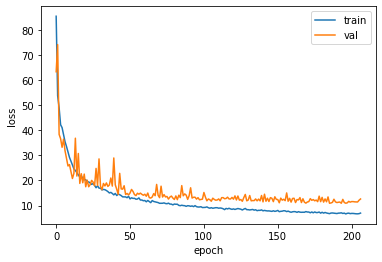

In [7]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()